In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Step 1: Load Data

data = pd.read_csv("mumbai-monthly-rains (2).csv")


In [5]:
data.isna().sum()

Year     0
Jan      0
Feb      0
Mar      0
April    0
May      0
June     0
July     0
Aug      0
Sept     0
Oct      0
Nov      0
Dec      0
Total    0
dtype: int64

In [7]:
# Set the Year as the index for time-series handling
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
data.set_index('Year', inplace=True)

In [9]:
# Focus on the total rainfall column
rainfall = data['Total']

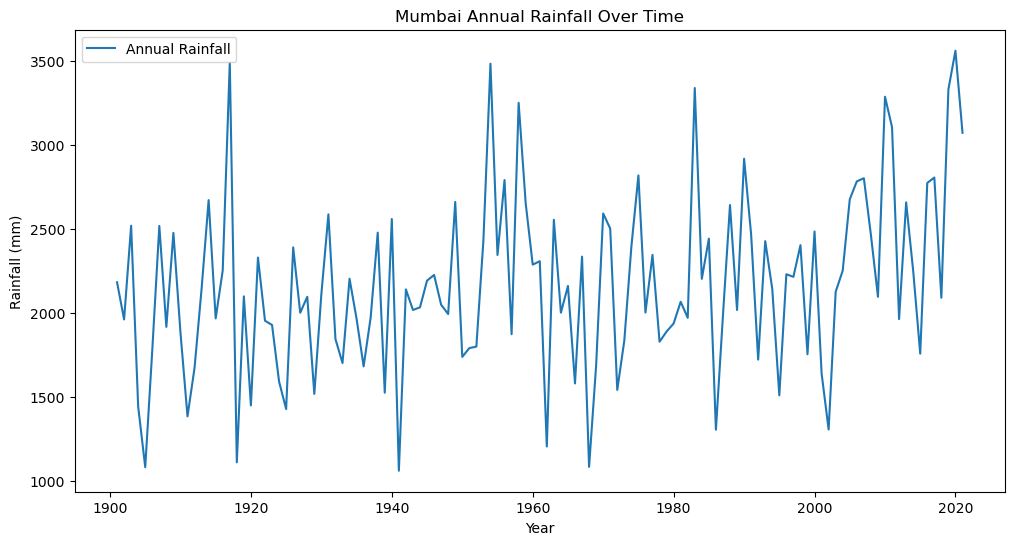

In [11]:
# Step 2: Visualize and Check for Trends
plt.figure(figsize=(12, 6))
plt.plot(rainfall, label="Annual Rainfall")
plt.title("Mumbai Annual Rainfall Over Time")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

In [13]:
# Step 3: Stationarity Check (ADF Test)
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary. Differencing might be required.")

check_stationarity(rainfall)

ADF Statistic: -9.550658170072023
p-value: 2.577245868023933e-16
Data is stationary.


In [17]:
# Step 4: Differencing (if needed)
rainfall_diff = rainfall.diff().dropna()


In [19]:
# Re-check stationarity
check_stationarity(rainfall_diff)

ADF Statistic: -7.805142118214298
p-value: 7.31551210894414e-12
Data is stationary.


In [21]:
# Step 5: ARIMA Model
# Fit an ARIMA model on the differenced data
p, d, q = 2, 1, 2  # Example parameters
arima_model = ARIMA(rainfall, order=(p, d, q))
arima_result = arima_model.fit()


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  wa

In [23]:
# Print summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  121
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -921.587
Date:                Wed, 20 Nov 2024   AIC                           1853.173
Time:                        20:04:12   BIC                           1867.111
Sample:                    01-01-1901   HQIC                          1858.833
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4507      3.690     -0.122      0.903      -7.684       6.782
ar.L2          0.0230      0.125      0.183      0.855      -0.223       0.269
ma.L1         -0.4604      3.688     -0.125      0.9

In [25]:
# Split data into train and test for evaluation (last 5 years)
train = rainfall[:-5]
test = rainfall[-5:]

In [27]:
predicted = arima_result.get_forecast(steps=5).predicted_mean

In [33]:
mae = mean_absolute_error(test, predicted)
mse = mean_squared_error(test, predicted)
print("\nARIMA Evaluation Metrics:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


ARIMA Evaluation Metrics:
Mean Absolute Error: 579.120712898273
Mean Squared Error: 402532.4208807126


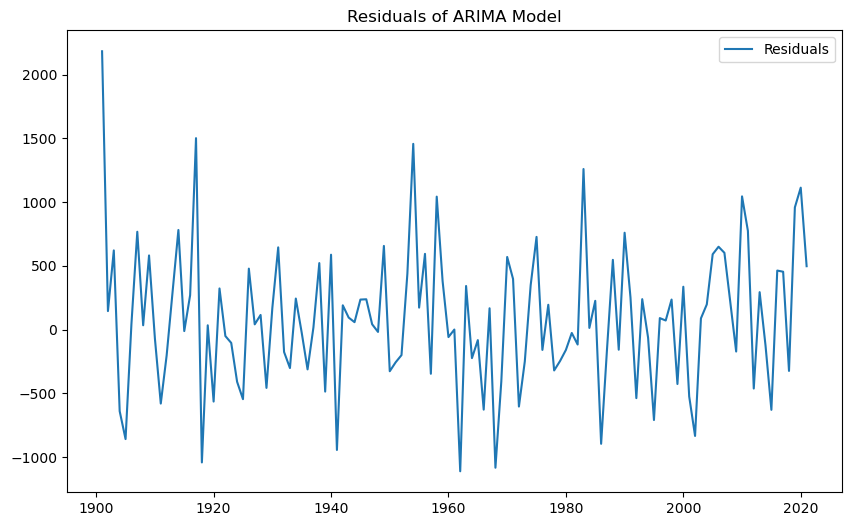

In [35]:
# Step 6: Plot ARIMA Residuals
plt.figure(figsize=(10, 6))
plt.plot(arima_result.resid, label="Residuals")
plt.title("Residuals of ARIMA Model")
plt.legend()
plt.show()

In [39]:
# Step 7: Forecast with ARIMA
forecast_years = 10  # Number of years to forecast
forecast = arima_result.get_forecast(steps=forecast_years)
forecast_index = pd.date_range(start=rainfall.index[-1], periods=forecast_years+1, freq='Y')[1:]
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

C:\Users\user\AppData\Local\Temp\ipykernel_10856\2877722200.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_index = pd.date_range(start=rainfall.index[-1], periods=forecast_years+1, freq='Y')[1:]


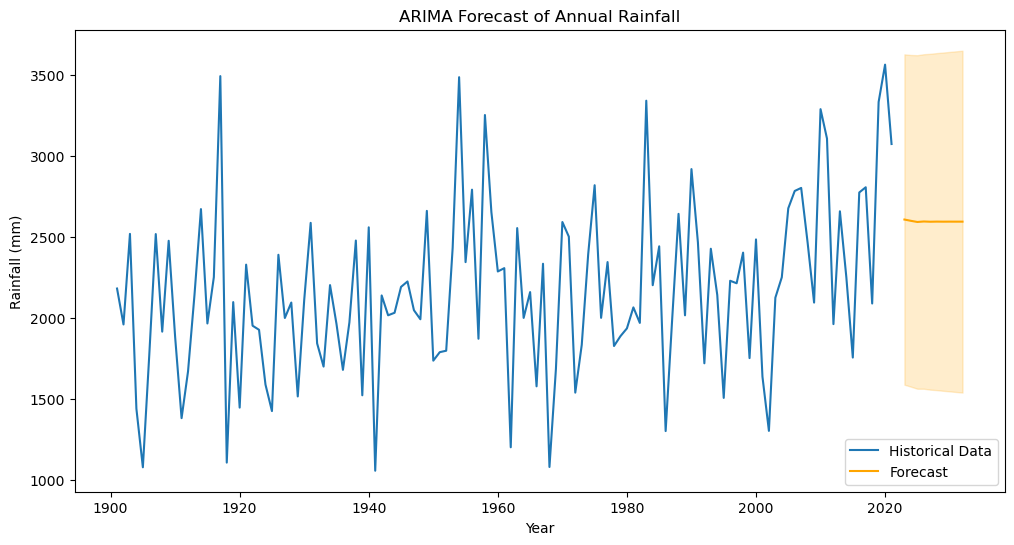

In [41]:
# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(rainfall, label="Historical Data")
plt.plot(forecast_index, forecast_mean, label="Forecast", color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.title("ARIMA Forecast of Annual Rainfall")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

#FINDINGS
This plot displays an ARIMA (AutoRegressive Integrated Moving Average) forecast of annual rainfall based on historical data. Here's the analysis:

Components of the Plot:
Historical Data (Blue Line):

Represents observed annual rainfall over time.
Similar to the SARIMA plot, the data exhibits high variability, with alternating peaks and troughs.
This variability suggests nonstationarity, which ARIMA accounts for by differencing the data.
Forecast (Orange Line):

The orange line depicts the future rainfall predictions by the ARIMA model.
The ARIMA forecast appears smoother and does not incorporate seasonal components.
Confidence Interval (Shaded Area):

The orange shaded area represents the uncertainty around the forecast.
It grows wider over time, indicating increasing uncertainty for longer-term predictions.
The interval appears slightly wider than in the SARIMA plot, possibly suggesting a greater level of uncertainty in this model's predictions.

In [43]:
# Step 8: SARIMA Model (with seasonality)
P, D, Q, m = 1, 1, 1, 4  # Example seasonal parameters
sarima_model = SARIMAX(rainfall, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_result = sarima_model.fit()

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [45]:
# Print summary
print(sarima_result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                  121
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -897.218
Date:                             Wed, 20 Nov 2024   AIC                           1808.436
Time:                                     20:05:05   BIC                           1827.711
Sample:                                 01-01-1901   HQIC                          1816.261
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9928      0.982      1.011      0.312      -0.932       2.917
ar.L2          0.0017      

In [47]:
# Step 9: SARIMA Forecast
sarima_forecast = sarima_result.get_forecast(steps=forecast_years)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_ci = sarima_forecast.conf_int()


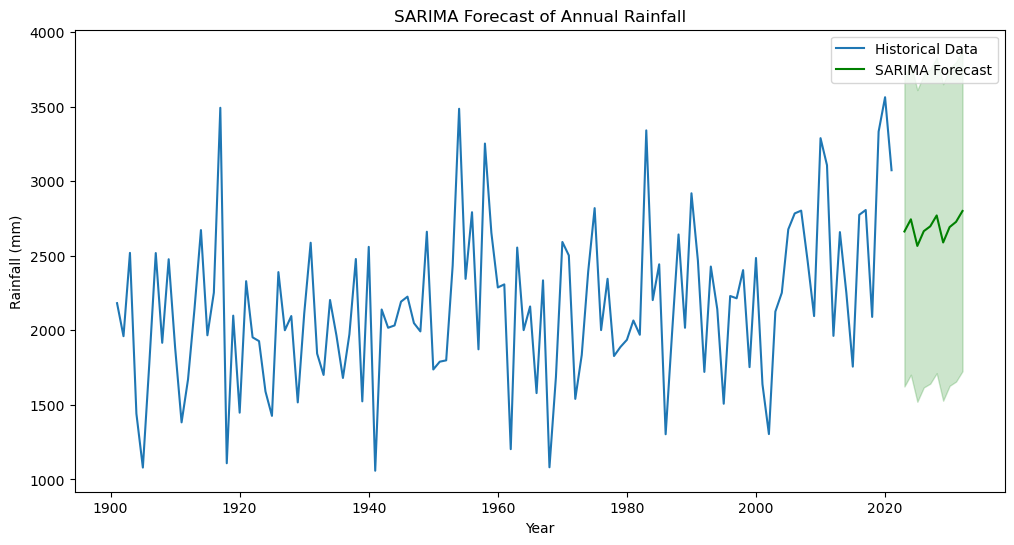

In [49]:
# Visualize SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(rainfall, label="Historical Data")
plt.plot(forecast_index, sarima_forecast_mean, label="SARIMA Forecast", color='green')
plt.fill_between(forecast_index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.title("SARIMA Forecast of Annual Rainfall")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

#Findings
This plot represents a SARIMA (Seasonal AutoRegressive Integrated Moving Average) forecast of annual rainfall based on historical data. Here's a detailed analysis:

Components of the Plot:
Historical Data (Blue Line):

Shows the observed annual rainfall over the years.
There is significant variability in the rainfall patterns over time.
Peaks and troughs indicate periods of unusually high and low rainfall.
SARIMA Forecast (Green Line):

The green line represents the forecasted rainfall using the SARIMA model.
It extends beyond the historical data to predict future values.
Confidence Interval (Shaded Area):

The light green shaded area represents the confidence interval around the forecast.
It provides a range within which the actual rainfall values are likely to fall.
Wider intervals suggest more uncertainty in the predictions.
Observations:
The SARIMA model appears to capture the general trend and seasonal patterns in the rainfall data.
The forecasted values indicate moderate variability, consistent with historical trends.
The confidence interval widens over time, reflecting increasing uncertainty in longer-term predictions.

In [35]:
# Step 10: Evaluation
# Split data into train and test for evaluation (last 5 years)
train = rainfall[:-5]
test = rainfall[-5:]

In [47]:
sarima_model_eval = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))


D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [49]:
sarima_result_eval = arima_model_eval.fit()

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
predicted = sarima_result_eval.get_forecast(steps=5).predicted_mean

In [53]:
# Metrics
mae = mean_absolute_error(test, predicted)
mse = mean_squared_error(test, predicted)
print("\nSARIMA Evaluation Metrics:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


SARIMA Evaluation Metrics:
Mean Absolute Error: 752.8312069729
Mean Squared Error: 687646.7100616927
